In [1]:
import networkx as nx
from matplotlib import pyplot as plt
import random
import math
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import threading
import queue

In [2]:
def distance(a, b):
    return math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

def exp_dist(x, y, density, graph):
    a = graph.nodes[x]['pos']
    b = graph.nodes[y]['pos']
    return math.exp(-distance(a, b)/density)

In [3]:
def initialize_graph(node_count, contact_radius = 1, queue = None, time = 0, edge_dist='geometric'):
    square_size = math.sqrt(node_count) #size of square
    custom_pos = {} #custom position for plotting
    G = nx.Graph(time = time) #initialize graph
    for i in range(node_count):
        G.add_node(i)
        G.nodes[i]['state'] = 'S'  
        x,y = random.uniform(0, square_size), random.uniform(0, square_size)
        G.nodes[i]['pos'] = (x,y)
        G.nodes[i]['observed'] = False
        G.nodes[i]['SIR_prob'] = [1,0,0]
        custom_pos[i] = (x,y)
    #initialize node state, color, and position
    #set the colors
    #S = susceptible (green)
    #I = infected (red)
    #R = recovered (blue)
    #set the edges
    edges = []
    if edge_dist == 'geometric':
        edges = nx.geometric_edges(G, radius = contact_radius)
    elif edge_dist == 'exp':
        matrix = np.fromfunction(exp_dist, (node_count, node_count), density = contact_radius, graph = G)
        pairs = np.array(np.triu_indices(node_count, k=1)).T
        for pair in pairs:
            i,j = pair
            if matrix[i,j] > random.uniform(0,1):
                    edges.append((i,j))
    G.add_edges_from(edges)
    queue.put((G, custom_pos))

In [4]:
def infectRandomNode(G, node_count):
    #infect a random node that is susceptible
    sample = random.sample(G.nodes(), G.number_of_nodes())
    count = 0
    for i in sample:
        if (count >= node_count):
            break
        if G.nodes[i]['state'] == 'S':
            G.nodes[i]['state'] = 'I'
        count += 1

In [5]:
def update(G_t1, G_t2, infection_rate, recovery_rate):
    #update Gt2 based on G_t1 assuming they are similar node size
    for node in G_t1.nodes():
        #check if node is observed
        G_t1.nodes[node]['observed'] = G_t2.nodes[node]['observed']
        
        #check node state
        if G_t1.nodes[node]['state'] == 'S':
            for neighbor in G_t1.neighbors(node):
                if G_t1.nodes[neighbor]['state'] == 'I':
                    if random.uniform(0, 1) < infection_rate:
                        G_t2.nodes[node]['state'] = 'I'
                        break
        elif G_t1.nodes[node]['state'] == 'I':
            if random.uniform(0, 1) < recovery_rate:
                G_t2.nodes[node]['state'] = 'R'
            else:
                G_t2.nodes[node]['state'] = 'I'
        else:
            G_t2.nodes[node]['state'] = 'R'
        
        #update SIR probabilities
        G_t2.nodes[node]['SIR_prob'] = G_t1.nodes[node]['SIR_prob']
    return G_t2

In [6]:
def SurroundInfectionRate(graph, node, infection_rate):
    #total infection rate of a node based on the infection rate of its neighbors
    neighbors = list(graph.neighbors(node))
    result = 0
    for neighbor in neighbors:
        result += infection_rate * graph.nodes[neighbor]['SIR_prob'][1]
    return result

In [7]:
def MeanFieldInference(graph_t, graph_t1, infection_rate, recovery_rate):
    predicted_state_t1 = {}
    for node in graph_t.nodes():
        if graph_t.nodes[node]['observed'] == True:
            predicted_state_t1[node] = graph_t.nodes[node]['SIR_prob']
            continue
        factor = SurroundInfectionRate(graph_t, node, infection_rate)
        Ps = graph_t.nodes[node]['SIR_prob'][0]*(1-factor)
        Pi = (1-recovery_rate)*graph_t.nodes[node]['SIR_prob'][1] + graph_t.nodes[node]['SIR_prob'][0]*factor
        Pr = graph_t.nodes[node]['SIR_prob'][2] + recovery_rate*graph_t.nodes[node]['SIR_prob'][1]
        predicted_state_t1[node] = [Ps, Pi, Pr]
        graph_t1.nodes[node]['SIR_prob'] = [Ps, Pi, Pr]
    return predicted_state_t1

In [8]:
def BackloopUpdate(temporal_graphs,t ,delta, node, state):
    mapper = {'S':[1,0,0], 'I':[0,1,0], 'R':[0,0,1]}
    for i in range(t, t-delta-1, -1):
        temporal_graphs[i][0].nodes[node]['SIR_prob'] = mapper[state]
        temporal_graphs[i][0].nodes[node]['observed'] = True

In [9]:
#@param: given a list of nodes that are observed
def DetectObserve(obs, temporal_graphs, observe_per_day, t, delta):
    list_of_nodes = []
    count = 0
    for entry in obs:
        state = temporal_graphs[t][0].nodes[entry]['state']
        obs_state = temporal_graphs[t][0].nodes[entry]['observed']
        if obs_state == True:
            continue
        BackloopUpdate(temporal_graphs, t, delta, entry, state)
        if count == observe_per_day:
            break
        count += 1
        list_of_nodes.append(entry)
    return list_of_nodes
        
        

In [10]:
def SetRemove(graph, list):
    for entry in list:
        graph.nodes[entry]['observed'] = True
        graph.nodes[entry]['SIR_prob'] = [0,0,1]
        graph.nodes[entry]['state'] = 'R'

In [11]:
def SIR_count(graph):
    S_count = 0
    I_count = 0
    R_count = 0
    for node in graph.nodes():
        if graph.nodes[node]['state'] == 'S':
            S_count += 1
        elif graph.nodes[node]['state'] == 'I':
            I_count += 1
        elif graph.nodes[node]['state'] == 'R':
            R_count += 1
    return S_count, I_count, R_count

In [12]:
def Sampler(graph, s_count):
    nodes = list(graph.nodes())
    random.shuffle(nodes)
    result = []
    count = 0
    for i in range(len(nodes)):
        if graph.nodes[nodes[i]]['observed']:
            result.append(nodes[i])
            count += 1
        if count == s_count:
            break
    return result

In [13]:
def generate_graphs(node_count, contact_radius, nr_graphs):
    que_graphs = queue.Queue()
    thread_list = []
    for t in range(0, nr_graphs):
        thread = threading.Thread(target=initialize_graph, args=(node_count, contact_radius, que_graphs, t, 'geometric'), name='thread'+str(t))
        thread.start()
        #print('thread'+str(t)+' started')
        thread_list.append(thread)
    for thread in tqdm(thread_list,desc='Generating Graphs Done'):
        #print('thread'+thread.name +' joined')
        thread.join()
    thread_list = []
    temporal_graph_dict = {}
    while not que_graphs.empty():
        G,custom_pos = que_graphs.get()
        temporal_graph_dict[G.graph['time']] = (G, custom_pos)
    return temporal_graph_dict

In [14]:
#mode = 'MF', 'R', 'None'
node_count = 10000
infection_rate = 0.05
recovery_rate = 0.01
contact_radius = 1
time_steps = 80
temporal_graph_dict = {}
observe_per_day = 5
t_mf = 5
delay = 10
mode = 'R'
color_map = {'S': 'green', 'I': 'red', 'R': 'blue'}
def sim(DataFrame, id, mode, queue = None):
    temporal_graph_dict = generate_graphs(node_count, contact_radius, time_steps)
    infectRandomNode(temporal_graph_dict[0][0], 1)
    graph = temporal_graph_dict[0][0]
    S, I, R = SIR_count(graph)
    DataFrame.loc[len(DataFrame)] = [id, 0, S, I, R]
    #string for description of loop:
    desc = 'Simulating (mode: '+mode +')'
    for i in tqdm(range(1, time_steps), desc=desc):
        graph = update(temporal_graph_dict[i-1][0], temporal_graph_dict[i][0], infection_rate, recovery_rate)
        if (mode == 'MF' and i > delay):
            pred = MeanFieldInference(temporal_graph_dict[i-1][0], graph, infection_rate, recovery_rate)
            sort_pred = sorted(pred.items(), key=lambda x: x[1])
            node_list = [node[0] for node in sort_pred]
            #print("day", i)
            #print(pred)
            #print(node_list)
            list_remove = DetectObserve(node_list, temporal_graph_dict,observe_per_day,i, t_mf)
            SetRemove(temporal_graph_dict[i][0], list_remove)
            for time in range(i-t_mf, i):
                pred = MeanFieldInference(temporal_graph_dict[time][0], temporal_graph_dict[time+1][0], infection_rate, recovery_rate)
        elif (mode == 'R' and i > delay):
            sample = Sampler(graph, observe_per_day)
            #DetectObserve(sample, temporal_graph_dict, i, t_mf)
            SetRemove(temporal_graph_dict[i], sample)
        S, I, R = SIR_count(graph)
        DataFrame.loc[len(DataFrame)] = [id, i, S, I, R]
    if queue != None:
        queue.put(DataFrame)
    return temporal_graph_dict

In [15]:
#Dataframe = pd.DataFrame(columns=['id', 'time', 'S', 'I', 'R'])
#tempograph = sim(Dataframe, 1, 'MF')
#for x in range(100):
    #sim(Dataframe, x, mode)

In [16]:
#parrallelize simulation per 20 threads
number_of_sim = 100
thread_sim = 20
thread_list = []
Dataframe_final = pd.DataFrame(columns=['id', 'time', 'S', 'I', 'R'])
Queu_sim = queue.Queue()
for x in tqdm(range(number_of_sim), desc='Simulating Main (mode: '+mode +')'):
    Dataframe = pd.DataFrame(columns=['id', 'time', 'S', 'I', 'R'])
    thread = threading.Thread(target=sim, args=(Dataframe, x, mode, Queu_sim), name='thread' + str(x))
    thread.start()
    thread_list.append(thread)
    if len(thread_list) >= thread_sim:
        #reduce thread list
        thread = thread_list.pop(0)
        thread.join()
for thread in tqdm(thread_list, desc='Reducing thread Simulating (mode: '+mode +')'):
    thread.join()
while not Queu_sim.empty():
    Dataframe = Queu_sim.get()
    Dataframe_final = Dataframe_final.append(Dataframe)

Simulating Main (mode: R):   0%|          | 0/100 [00:00<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:34<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:04<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:14<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:40<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:51<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:01<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:05<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:01<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:01<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:08<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:08<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:06<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:30<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:01<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:29<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:38<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:16<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:13<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:06<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:30<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Simulating (mode: R):   0%|          | 0/79 [00:00<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:00<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:07<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:16<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:18<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:28<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:32<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:35<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:36<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:40<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:40<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:40<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:45<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:47<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:53<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:55<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:55<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [01:03<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [01:10<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [01:11<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [01:32<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [01:41<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [02:15<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Generating Graphs Done:   0%|          | 0/80 [00:52<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:23<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [04:37<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:03<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:00<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [01:08<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:55<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:00<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:11<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:01<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Generating Graphs Done:   0%|          | 0/80 [03:14<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())
C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())
C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Simulating (mode: R):   0%|          | 0/79 [00:03<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [04:42<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Generating Graphs Done:   0%|          | 0/80 [00:25<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [04:44<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Generating Graphs Done:   0%|          | 0/80 [00:09<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())
C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Generating Graphs Done:   0%|          | 0/80 [01:36<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Simulating (mode: R):   0%|          | 0/79 [01:06<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [01:41<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [01:48<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [01:49<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:20<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Simulating (mode: R):   0%|          | 0/79 [01:55<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [02:20<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Simulating (mode: R):   0%|          | 0/79 [01:56<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:33<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Generating Graphs Done:   0%|          | 0/80 [00:42<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Generating Graphs Done:   0%|          | 0/80 [05:28<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [01:51<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [01:55<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [01:50<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Generating Graphs Done:   0%|          | 0/80 [02:17<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [02:11<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [02:14<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [02:36<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:31<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:45<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [02:45<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:39<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:41<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [01:23<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:57<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:38<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:51<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:04<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:54<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())
C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())
C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Simulating (mode: R):   0%|          | 0/79 [04:35<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:00<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:04<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [04:34<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:11<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [01:04<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [04:34<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())
C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())
C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Generating Graphs Done:   0%|          | 0/80 [00:02<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())
C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Generating Graphs Done:   0%|          | 0/80 [00:22<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:33<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:13<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:32<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Generating Graphs Done:   0%|          | 0/80 [01:32<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [01:27<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [01:44<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:00<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [02:20<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Generating Graphs Done:   0%|          | 0/80 [01:49<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Generating Graphs Done:   0%|          | 0/80 [01:28<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [02:23<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:00<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:12<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [01:36<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [01:37<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [01:43<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:31<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:32<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [01:52<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:36<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [01:52<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:39<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [02:26<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:48<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:47<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [01:12<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:39<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:47<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:47<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:39<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())
C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())
C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())
C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Simulating (mode: R):   0%|          | 0/79 [00:53<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:53<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:54<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:56<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:01<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:01<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:58<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Generating Graphs Done:   0%|          | 0/80 [00:54<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:01<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:04<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())
C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())
C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Simulating (mode: R):   0%|          | 0/79 [00:08<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:08<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [01:22<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [01:44<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Generating Graphs Done:   0%|          | 0/80 [02:47<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [03:44<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [03:01<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:57<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [03:08<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:00<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:05<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Generating Graphs Done:   0%|          | 0/80 [01:01<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Generating Graphs Done:   0%|          | 0/80 [01:18<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Simulating (mode: R):   0%|          | 0/79 [02:26<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:11<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Generating Graphs Done:   0%|          | 0/80 [01:11<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Generating Graphs Done:   0%|          | 0/80 [02:09<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:00<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:14<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:26<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Generating Graphs Done:   0%|          | 0/80 [02:21<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Generating Graphs Done:   0%|          | 0/80 [01:16<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:28<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [04:11<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Simulating (mode: R):   0%|          | 0/79 [00:33<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:38<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:35<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:35<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Simulating (mode: R):   0%|          | 0/79 [02:43<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [01:25<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [01:24<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:54<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:48<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:56<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:34<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())
C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Simulating (mode: R):   0%|          | 0/79 [00:49<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [01:20<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [01:02<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [01:14<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [01:21<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:48<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:25<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:48<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Generating Graphs Done:   0%|          | 0/80 [01:16<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [01:19<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [01:33<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [01:24<?, ?it/s]

Reducing thread Simulating (mode: R):   0%|          | 0/19 [01:02<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [01:33<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [01:26<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:16<?, ?it/s]

Generating Graphs Done:   0%|          | 0/80 [00:06<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:23<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Generating Graphs Done:   0%|          | 0/80 [00:07<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())
C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())
C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())
C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\3500474817.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sample = random.sample(G.nodes(), G.number_of_nodes())


Simulating (mode: R):   0%|          | 0/79 [00:03<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:08<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:15<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:20<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:26<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:26<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:30<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:35<?, ?it/s]

Simulating (mode: R):   0%|          | 0/79 [00:36<?, ?it/s]

C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\1105863710.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Dataframe_final = Dataframe_final.append(Dataframe)
C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\1105863710.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Dataframe_final = Dataframe_final.append(Dataframe)
C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\1105863710.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Dataframe_final = Dataframe_final.append(Dataframe)
C:\Users\Frank\AppData\Local\Temp\ipykernel_23304\1105863710.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Dataframe_final = Dataframe_fina

In [17]:
string_df = 'Dataframe'+str(node_count)+'_'+str(infection_rate)+'_'+str(recovery_rate)+'_'+str(contact_radius)+'_'+str(time_steps)+'_'+str(observe_per_day)+'_'+str(t_mf)+ str(mode)+'geo.csv'
Dataframe_final.to_csv(string_df, index=False)

In [18]:
def drawgraph(tempograph, t):
    graph = tempograph[t][0]
    custom_pos = tempograph[t][1]
    colors = [color_map[graph.nodes[node]['state']] for node in graph.nodes()]
    nx.draw(graph, pos = custom_pos, node_color = colors, with_labels = True)

In [19]:
from ipywidgets import *
interact(drawgraph, tempograph = fixed(tempograph), t = widgets.IntSlider(min=0, max=time_steps-1, step=1, value=0))

NameError: name 'tempograph' is not defined

<Axes: xlabel='time'>

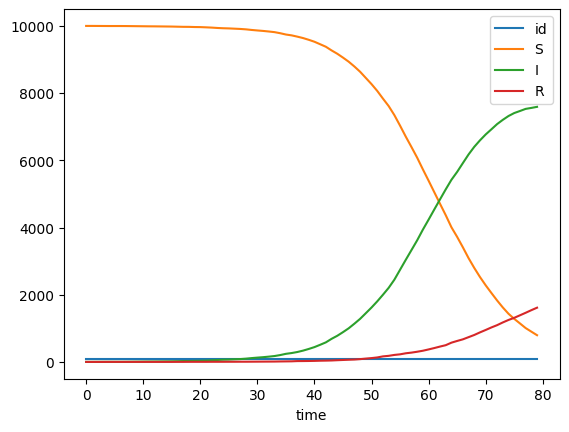

In [20]:
Dataframe.groupby('time').mean().plot()

In [ ]:
fig, ax = plt.subplots()
plt.plot(DataframeMf.groupby('time').mean()['I'], label='MF')
plt.plot(Dataframe.groupby('time').mean()['I'], label='R')
plt.legend()